In [149]:
import os
import xarray as xr
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader, IterableDataset


In [2]:
d = xr.open_dataset('/scratch/smrserraoseabr/Projects/FluvialCO2/results32/simulation_results_realization_32x32_1.nc')

In [3]:
d

<xarray.Dataset>
Dimensions:          (time: 61, origin: 1, Y: 32, X: 32)
Coordinates:
  * time             (time) int64 0 30 60 90 120 ... 1680 1710 1740 1770 1800
  * origin           (origin) object 'INJ'
  * X                (X) float64 6.25 57.46 108.7 ... 1.543e+03 1.594e+03
  * Y                (Y) float64 6.25 57.46 108.7 ... 1.543e+03 1.594e+03
Data variables: (12/22)
    FIPS_c_1         (time) float32 ...
    p_0_reservoir_P  (origin, time) float32 ...
    BHP              (origin, time) float32 ...
    p_0_c_2_rate     (origin, time) float32 ...
    gas_rate         (origin, time) float32 ...
    FIPS_c_0         (time) float32 ...
    ...               ...
    CO_2             (time, Y, X) float32 ...
    C_1              (time, Y, X) float32 ...
    H2O              (time, Y, X) float32 ...
    Perm             (Y, X) float32 ...
    Por              (Y, X) float32 ...
    Facies           (Y, X) float32 ...

In [141]:
class XarrayDataset(Dataset):  #deprecated
    def __init__(self, folder, input_vars, output_vars):
        self.folder = folder
        self.file_list = os.listdir(folder)
        self.input_vars = input_vars
        self.input_vars.append('x_encoding')
        self.input_vars.append('y_encoding')
        self.input_vars.append('time_encoding')
        self.output_vars = output_vars

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        file_path = os.path.join(self.folder, self.file_list[idx])
        data = xr.open_dataset(file_path)
        # Add the meshgrids as new data variables in the xarray
        X = data['X'].values
        Y = data['Y'].values
        TIME = data['time'].values

        # Create meshgrids for X and Y dimensions
        x_mesh, y_mesh = np.meshgrid(data.X, data.Y, indexing='ij')
        TIME_MESH = np.meshgrid(data.time, data.X, data.Y, indexing='ij')
        data = data.assign(x_encoding=xr.DataArray(x_mesh, coords=[("X", X), ("Y", Y)]))
        data = data.assign(y_encoding=xr.DataArray(y_mesh, coords=[("X", X), ("Y", Y)]))
        data = data.assign(time_encoding=xr.DataArray(TIME_MESH[0], coords=[("time", TIME), ("X", X), ("Y", Y)]))

        # Concatenate input variables along a new dimension
        input_data_list = []
        for var in self.input_vars:
            if 'time' in data[var].dims:
                input_data_list.append(torch.tensor(data[var].values, dtype=torch.float32).unsqueeze(0))
            else:
                scalar_matrix = torch.tensor(data[var].values, dtype=torch.float32).expand(data.time.size, -1, -1)
                input_data_list.append(scalar_matrix.unsqueeze(0))

        input_data = torch.cat(input_data_list, dim=0)
        input_data = input_data.permute(1, 2, 3, 0)  # Reorder dimensions to (time, shape[0], shape[1], channels)

        # Concatenate output variables along a new dimension
        output_data_list = [torch.tensor(data[var].values, dtype=torch.float32).unsqueeze(0) for var in self.output_vars]
        output_data = torch.cat(output_data_list, dim=0)
        output_data = output_data.permute(1, 2, 3, 0)  # Reorder dimensions to (time, shape[0], shape[1], channels)

        return input_data, output_data

folder = "/scratch/smrserraoseabr/Projects/FluvialCO2/results32"
input_vars = ['Por', 'Perm', 'Pressure'] # Porosity, Permeability, Pressure + x, y, time encodings 
output_vars = ['Pressure']

# Create a dataset and DataLoader
dataset = XarrayDataset(folder, input_vars, output_vars)
dataloader = DataLoader(dataset, batch_size=25, shuffle=True, num_workers=1)

# Test the dataloader by loading a few batches
num_batches_to_check = 1
for i, (input_data, output_data) in enumerate(dataloader):
    if i >= num_batches_to_check:
        break

    print(f"Batch {i+1}:")
    print(f"Input data shape: {input_data.shape}")
    print(f"Output data shape: {output_data.shape}")

Batch 1:
Input data shape: torch.Size([25, 61, 32, 32, 6])


In [150]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Read dataset

In [151]:
class ReadXarrayDataset():
    def __init__(self, folder, input_vars, output_vars, device='cpu', num_files=None, is_train = True):
        self.folder = folder
        if is_train:
            self.file_list = os.listdir(folder)[:num_files] if num_files else os.listdir(folder)
        else:
            self.file_list = os.listdir(folder)[num_files:] if num_files else os.listdir(folder)
            
        self.input_vars = input_vars
        self.input_vars.append('x_encoding')
        self.input_vars.append('y_encoding')
        self.input_vars.append('time_encoding')
        self.output_vars = output_vars
        self.device = device
        
        input_data_list = []
        output_data_list = []
        
        #iterate inside the folder
        for i in range(len(self.file_list)):
            file_path = os.path.join(self.folder, self.file_list[i])
            data = xr.open_dataset(file_path)
            
            # Add the meshgrids as new data variables in the xarray
            X = data['X'].values
            Y = data['Y'].values
            TIME = data['time'].values

            # Create meshgrids for X and Y dimensions
            x_mesh, y_mesh = np.meshgrid(data.X, data.Y, indexing='ij')
            TIME_MESH = np.meshgrid(data.time, data.X, data.Y, indexing='ij')
            data = data.assign(x_encoding=xr.DataArray(x_mesh, coords=[("X", X), ("Y", Y)]))
            data = data.assign(y_encoding=xr.DataArray(y_mesh, coords=[("X", X), ("Y", Y)]))
            data = data.assign(time_encoding=xr.DataArray(TIME_MESH[0], coords=[("time", TIME), ("X", X), ("Y", Y)]))

            # Append input variables to list
            input_data = []
            for var in self.input_vars:
                if 'time' in data[var].dims:
                    input_data.append(torch.tensor(data[var].values, dtype=torch.float32))
                else:
                    scalar_matrix = torch.tensor(data[var].values, dtype=torch.float32).expand(data.time.size, -1, -1)
                    input_data.append(scalar_matrix)

            # Append output variables to list
            output_data = []
            for var in self.output_vars:
                output_data.append(torch.tensor(data[var].values, dtype=torch.float32))

            # Concatenate input variables along new dimension
            input_data_list.append(torch.stack(input_data, dim=-1))

            # Concatenate output variables along new dimension
            output_data_list.append(torch.stack(output_data, dim=-1))

        # Concatenate input variables along new dimension
        input_data = torch.stack(input_data_list, dim=0)

        # Concatenate output variables along new dimension
        output_data = torch.stack(output_data_list, dim=0)

        # Swap order of time and channel dimensions
        input_data = input_data.permute(0,1, 2, 3, 4)
        output_data = output_data.permute(0,1, 2, 3, 4)

        self.input_data = input_data
        self.output_data = output_data



# normalization, pointwise gaussian
class UnitGaussianNormalizer(object):
    def __init__(self, x, eps=0.00001, time_last=True):
        super(UnitGaussianNormalizer, self).__init__()

        self.mean = torch.mean(x, dim=(0, 1, 2))
        self.std = torch.std(x, dim=(0, 1, 2))
        self.eps = eps


    def encode(self, x):
        x = (x - self.mean) / (self.std + self.eps)
        return x

    def decode(self, x):
        std = self.std + self.eps # n
        mean = self.mean
        x = (x * std) + mean
        return x




In [152]:
folder = "/scratch/smrserraoseabr/Projects/FluvialCO2/results32"
input_vars = ['Por', 'Perm', 'Pressure'] # Porosity, Permeability, Pressure + x, y, time encodings 
output_vars = ['Pressure']

# Create instance of ReadXarrayDataset class
dataset = ReadXarrayDataset(folder=folder, input_vars=input_vars, output_vars=output_vars, num_files=100, is_train=True)

# Get input and output data tensors
input_data = dataset.input_data
output_data = dataset.output_data

# Print shapes of input and output data tensors
print("Input data shape:", input_data.shape)
print("Output data shape:", output_data.shape)

# Move data tensors to GPU if available
device = 'cuda' if torch.cuda.is_available() else 'cpu'
input_data = input_data.to(device)
output_data = output_data.to(device)

Input data shape: torch.Size([100, 61, 32, 32, 6])
Output data shape: torch.Size([100, 61, 32, 32, 1])


Normalize dataset

In [153]:
# Normalize input_data and output_data
train_a = input_data
train_u = output_data
a_normalizer = UnitGaussianNormalizer(train_a)
train_a_normalized = a_normalizer.encode(train_a)
y_normalizer = UnitGaussianNormalizer(train_u)
train_u_normalized = y_normalizer.encode(train_u)

# Denormalize the normalized data
train_a_denormalized = a_normalizer.decode(train_a_normalized)
train_u_denormalized = y_normalizer.decode(train_u_normalized)

# Check if the original data and the denormalized data are the same
input_data_error = torch.mean((train_a - train_a_denormalized)**2).item()
output_data_error = torch.mean((train_u - train_u_denormalized)**2).item()

print("Input data error: ", input_data_error)
print("Output data error: ", output_data_error)

# Check if the errors are within an acceptable tolerance
tolerance = 1e-6
assert input_data_error < tolerance, "Input data denormalization error is too high"
assert output_data_error < tolerance, "Output data denormalization error is too high"

print("Encode and decode functions are working properly")


Input data error:  9.049314249331974e-12
Output data error:  1.514308643757456e-12
Encode and decode functions are working properly


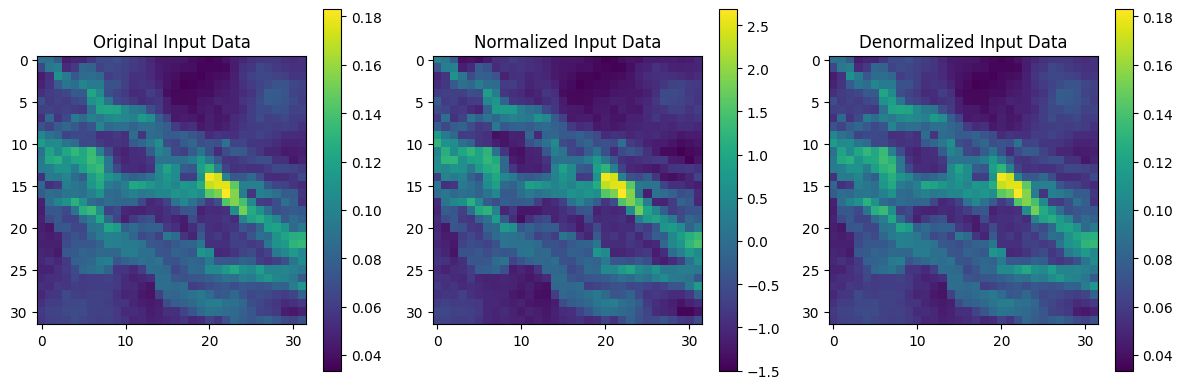

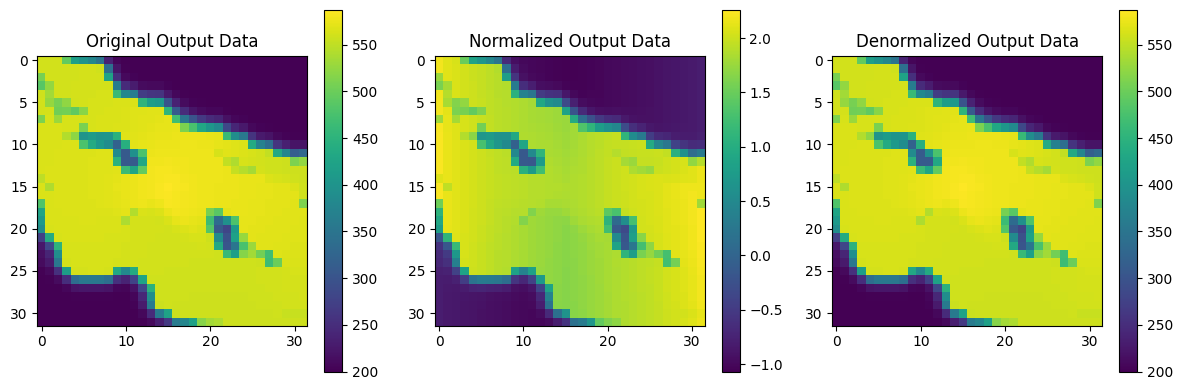

In [154]:
import matplotlib.pyplot as plt

# Select the first sample and the first channel to visualize
sample_idx = 0
channel_idx = 0
time_step = 60

# Original input data
plt.figure(figsize=(12, 4))
plt.subplot(131)
plt.imshow(train_a[sample_idx, time_step, :, : , channel_idx], cmap='viridis')
plt.title("Original Input Data")
plt.colorbar()

# Normalized input data
plt.subplot(132)
plt.imshow(train_a_normalized[sample_idx, time_step, :, : , channel_idx], cmap='viridis')
plt.title("Normalized Input Data")
plt.colorbar()

# Denormalized input data
plt.subplot(133)
plt.imshow(train_a_denormalized[sample_idx, time_step, :, : , channel_idx], cmap='viridis')
plt.title("Denormalized Input Data")
plt.colorbar()

plt.tight_layout()
plt.show()

# Original output data
plt.figure(figsize=(12, 4))
plt.subplot(131)
plt.imshow(train_u[sample_idx, time_step, :, : , channel_idx], cmap='viridis')
plt.title("Original Output Data")
plt.colorbar()

# Normalized output data
plt.subplot(132)
plt.imshow(train_u_normalized[sample_idx, time_step, :, : , channel_idx], cmap='viridis')
plt.title("Normalized Output Data")
plt.colorbar()

# Denormalized output data
plt.subplot(133)
plt.imshow(train_u_denormalized[sample_idx, time_step, :, : , channel_idx], cmap='viridis')
plt.title("Denormalized Output Data")
plt.colorbar()

plt.tight_layout()
plt.show()


##Reading from the zip file - Still need to figure out how to read from the zip file

In [31]:
import zipfile
import io
class XarrayDataset(Dataset):
    def __init__(self, zip_file_path, input_vars, output_vars):
        self.zip_file_path = zip_file_path
        self.input_vars = input_vars
        self.input_vars.append('x_encoding')
        self.input_vars.append('y_encoding')
        self.input_vars.append('time_encoding')
        self.output_vars = output_vars

        with zipfile.ZipFile(self.zip_file_path, 'r') as zip_ref:
            self.file_list = [f for f in zip_ref.namelist() if f.endswith('.nc')]

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        with zipfile.ZipFile(self.zip_file_path, 'r') as zip_ref:
            file_path = self.file_list[idx]
            with zip_ref.open(file_path, 'r') as file:
                data = xr.open_dataset(io.BytesIO(file.read()) , engine='scipy')
        # Add the meshgrids as new data variables in the xarray
        X = data['X'].values
        Y = data['Y'].values
        TIME = data['time'].values

        # Create meshgrids for X and Y dimensions
        x_mesh, y_mesh = np.meshgrid(data.X, data.Y, indexing='ij')
        TIME_MESH = np.meshgrid(data.time, data.X, data.Y, indexing='ij')
        data = data.assign(x_encoding=xr.DataArray(x_mesh, coords=[("X", X), ("Y", Y)]))
        data = data.assign(y_encoding=xr.DataArray(y_mesh, coords=[("X", X), ("Y", Y)]))
        data = data.assign(time_encoding=xr.DataArray(TIME_MESH[0], coords=[("time", TIME), ("X", X), ("Y", Y)]))

        # Concatenate input variables along a new dimension
        input_data_list = []
        for var in self.input_vars:
            if 'time' in data[var].dims:
                input_data_list.append(torch.tensor(data[var].values, dtype=torch.float32).unsqueeze(0))
            else:
                scalar_matrix = torch.tensor(data[var].values, dtype=torch.float32).expand(data.time.size, -1, -1)
                input_data_list.append(scalar_matrix.unsqueeze(0))

        input_data = torch.cat(input_data_list, dim=0)
        input_data = input_data.permute(1, 2, 3, 0)  # Reorder dimensions to (time, shape[0], shape[1], channels)

        # Concatenate output variables along a new dimension
        output_data_list = [torch.tensor(data[var].values, dtype=torch.float32).unsqueeze(0) for var in self.output_vars]
        output_data = torch.cat(output_data_list, dim=0)
        output_data = output_data.permute(1, 2, 3, 0)  # Reorder dimensions to (time, shape[0], shape[1], channels)

        return input_data, output_data

In [77]:
zip_file_path = "/scratch/smrserraoseabr/Projects/FluvialCO2/results32.zip"
input_vars = ['Por', 'Perm']
output_vars = ['Pressure']

# Create a dataset and DataLoader
dataset = XarrayDataset(zip_file_path, input_vars, output_vars)
dataloader = DataLoader(dataset, batch_size=5, shuffle=True, num_workers=1)

# Test the dataloader by loading a few batches
num_batches_to_check = 5
for i, (input_data, output_data) in enumerate(dataloader):
    if i >= num_batches_to_check:
        break

    print(f"Batch {i+1}:")
    print(f"Input data shape: {input_data.shape}")
    print(f"Output data shape: {output_data.shape}")


TypeError: Caught TypeError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/home/smrserraoseabr/.local/lib/python3.8/site-packages/xarray/backends/scipy_.py", line 102, in _open_scipy_netcdf
    return scipy.io.netcdf_file(filename, mode=mode, mmap=mmap, version=version)
  File "/home/smrserraoseabr/.local/lib/python3.8/site-packages/scipy/io/_netcdf.py", line 277, in __init__
    self._read()
  File "/home/smrserraoseabr/.local/lib/python3.8/site-packages/scipy/io/_netcdf.py", line 598, in _read
    raise TypeError("Error: %s is not a valid NetCDF 3 file" %
TypeError: Error: None is not a valid NetCDF 3 file

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/smrserraoseabr/.local/lib/python3.8/site-packages/torch/utils/data/_utils/worker.py", line 302, in _worker_loop
    data = fetcher.fetch(index)
  File "/home/smrserraoseabr/.local/lib/python3.8/site-packages/torch/utils/data/_utils/fetch.py", line 49, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/home/smrserraoseabr/.local/lib/python3.8/site-packages/torch/utils/data/_utils/fetch.py", line 49, in <listcomp>
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/tmp/ipykernel_2981016/2060069648.py", line 21, in __getitem__
    data = xr.open_dataset(io.BytesIO(file.read()) , engine='scipy')
  File "/home/smrserraoseabr/.local/lib/python3.8/site-packages/xarray/backends/api.py", line 531, in open_dataset
    backend_ds = backend.open_dataset(
  File "/home/smrserraoseabr/.local/lib/python3.8/site-packages/xarray/backends/scipy_.py", line 279, in open_dataset
    store = ScipyDataStore(
  File "/home/smrserraoseabr/.local/lib/python3.8/site-packages/xarray/backends/scipy_.py", line 154, in __init__
    scipy_dataset = _open_scipy_netcdf(
  File "/home/smrserraoseabr/.local/lib/python3.8/site-packages/xarray/backends/scipy_.py", line 113, in _open_scipy_netcdf
    raise TypeError(errmsg)
TypeError: Error: None is not a valid NetCDF 3 file
            If this is a NetCDF4 file, you may need to install the
            netcdf4 library, e.g.,

            $ pip install netcdf4
            


In [78]:
!pip install netCDF4


Defaulting to user installation because normal site-packages is not writeable


In [ ]:
import os
import zipfile
import xarray as xr
import torch
from torch.utils.data import IterableDataset

class XarrayDataset(IterableDataset):
    def __init__(self, zip_file, input_vars_time_varying, input_vars_time_fixed, output_vars):
        self.zip_file = zipfile.ZipFile(zip_file, 'r')
        self.file_list = self.zip_file.namelist()
        self.input_vars_time_varying = input_vars_time_varying
        self.input_vars_time_fixed = input_vars_time_fixed
        self.output_vars = output_vars

    def __len__(self):
        return len(self.file_list)

    def read_xarray_file(self, file_path):
        with self.zip_file.open(file_path) as file:
            data = xr.open_dataset(file, engine='netcdf4', backend_kwargs={'mode': 'r'})

            input_data_time_varying = torch.cat([torch.tensor(data[var].values, dtype=torch.float32).unsqueeze(-1) for var in self.input_vars_time_varying], dim=-1)
            input_data_time_fixed = torch.cat([torch.tensor(data[var].values, dtype=torch.float32).unsqueeze(-1) for var in self.input_vars_time_fixed], dim=-1)
            output_data = torch.cat([torch.tensor(data[var].values, dtype=torch.float32).unsqueeze(-1) for var in self.output_vars], dim=-1)

        return input_data_time_varying, input_data_time_fixed, output_data

    def __iter__(self):
        for file_path in self.file_list:
            yield self.read_xarray_file(file_path)


In [10]:
#read from the zip folder
class XarrayDatasetZip(Dataset):
    def __init__(self, zip_file, input_vars, output_vars):
        self.zip_file = zipfile.ZipFile(zip_file, 'r')
        self.file_list = self.zip_file.namelist()
        self.input_vars = input_vars
        self.output_vars = output_vars


    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        file_path = self.file_list[idx]

        # Read xarray file directly from the zip file
        with self.zip_file.open(file_path) as file:
            data = xr.open_dataset(file, engine='netcdf4', backend_kwargs={'mode': 'r'})



            # Concatenate input variables along a new dimension
            input_data = torch.cat([torch.tensor(data[var].values, dtype=torch.float32).unsqueeze(-1) for var in input_vars], dim=-1)

            # Concatenate output variables along a new dimension
            output_data = torch.cat([torch.tensor(data[var].values, dtype=torch.float32).unsqueeze(-1) for var in output_vars], dim=-1)

        return input_data, output_data

In [35]:
class XarrayDatasetZipIter(IterableDataset):
    def __init__(self, zip_file, input_vars, output_vars):
        self.zip_file = zipfile.ZipFile(zip_file, 'r')
        self.file_list = self.zip_file.namelist()
        self.input_vars = input_vars
        self.output_vars = output_vars

    def __len__(self):
        return len(self.file_list)

    def read_xarray_file(self, file_path):
        with self.zip_file.open(file_path) as file:
            data = xr.open_dataset(file, backend_kwargs={'mode': 'r'})



            input_data = torch.cat([torch.tensor(data[var].values, dtype=torch.float32).unsqueeze(-1) for var in input_vars], dim=-1)
            output_data = torch.cat([torch.tensor(data[var].values, dtype=torch.float32).unsqueeze(-1) for var in output_vars], dim=-1)

        return input_data, output_data

    def __iter__(self):
        for file_path in self.file_list:
            yield self.read_xarray_file(file_path)

In [36]:
""""
Note that we set batch_size=None in the DataLoader. This is because IterableDataset does not support automatic batching, so you'll need to handle batching manually in your training loop.
"""
input_vars = ['Por', 'Perm']
output_vars = ['GasSat', 'Pressure', 'CO_2']
folder_zip="/scratch/smrserraoseabr/Projects/FluvialCO2/results32.zip"
#dataset = XarrayDataset(folder, input_vars, output_vars)
#dataloader = DataLoader(dataset, batch_size=32, shuffle=True, num_workers=4)
dataset = XarrayDatasetZipIter(folder_zip, input_vars, output_vars)
dataloader = DataLoader(dataset, batch_size=None, num_workers=4)

In [37]:
# Test the dataloader by loading a few batches
num_batches_to_check = 5

for i, (input_data, output_data) in enumerate(dataloader):
    print(f"Batch {i+1}:")
    print(f"Input data shape: {input_data.shape}")
    print(f"Output data shape: {output_data.shape}")
    print(f"Input data: {input_data}")
    print(f"Output data: {output_data}")
    print("\n")

    if i >= num_batches_to_check - 1:
        break


ValueError: Caught ValueError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/home/smrserraoseabr/.local/lib/python3.8/site-packages/torch/utils/data/_utils/worker.py", line 302, in _worker_loop
    data = fetcher.fetch(index)
  File "/home/smrserraoseabr/.local/lib/python3.8/site-packages/torch/utils/data/_utils/fetch.py", line 39, in fetch
    data = next(self.dataset_iter)
  File "/tmp/ipykernel_2941125/2706523513.py", line 24, in __iter__
    yield self.read_xarray_file(file_path)
  File "/tmp/ipykernel_2941125/2706523513.py", line 13, in read_xarray_file
    data = xr.open_dataset(file, backend_kwargs={'mode': 'r'})
  File "/home/smrserraoseabr/.local/lib/python3.8/site-packages/xarray/backends/api.py", line 515, in open_dataset
    engine = plugins.guess_engine(filename_or_obj)
  File "/home/smrserraoseabr/.local/lib/python3.8/site-packages/xarray/backends/plugins.py", line 155, in guess_engine
    raise ValueError(error_msg)
ValueError: did not find a match in any of xarray's currently installed IO backends ['netcdf4', 'scipy']. Consider explicitly selecting one of the installed engines via the ``engine`` parameter, or installing additional IO dependencies, see:
https://docs.xarray.dev/en/stable/getting-started-guide/installing.html
https://docs.xarray.dev/en/stable/user-guide/io.html


In [30]:
dataloader

In [ ]:
""""
def train_epoch(dataloader, model, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    n_batches = 0

    batch_inputs = []
    batch_outputs = []
    batch_size = 32

    for inputs, outputs in dataloader:
        batch_inputs.append(inputs.to(device))
        batch_outputs.append(outputs.to(device))

        if len(batch_inputs) == batch_size:
            inputs_batch = torch.stack(batch_inputs)
            outputs_batch = torch.stack(batch_outputs)

            optimizer.zero_grad()
            predictions = model(inputs_batch)
            loss = criterion(predictions, outputs_batch)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            n_batches += 1

            batch_inputs.clear()
            batch_outputs.clear()

    return running_loss / n_batches
"""

In [ ]:
import zipfile
import torch
from torchvision import transforms
from PIL import Image
import io

def load_image_from_zip(zip_path, file_path):
    with zipfile.ZipFile(zip_path, 'r') as z:
        with z.open(file_path) as f:
            img = Image.open(io.BytesIO(f.read()))
            transform = transforms.Compose([
                transforms.Resize((224, 224)),
                transforms.ToTensor(),
            ])
            img_tensor = transform(img)
            return img_tensor

zip_path = "path/to/your/zipfile.zip"
file_path = "path/to/your/image.jpg"

img_tensor = load_image_from_zip(zip_path, file_path)
print(img_tensor.shape)


In [15]:
import zipfile
import xarray as xr
import torch
from torch.utils.data import IterableDataset



In [16]:
zip_path = r'/scratch/smrserraoseabr/Projects/FluvialCO2/results32.zip'

In [18]:
zip_file = zipfile.ZipFile(zip_path, 'r')
    

In [21]:
len(zip_file.namelist()[1:])

1000

In [24]:
zipfile.ZipFile(zip_path, 'r')

<zipfile.ZipFile filename='/scratch/smrserraoseabr/Projects/FluvialCO2/results32.zip' mode='r'>

In [25]:
with zip_file.open(file_path) as file:
        data = xr.open_dataset(file, engine='netcdf4', backend_kwargs={'mode': 'r'})




NameError: name 'file_path' is not defined

In [ ]:
file_list = zip_file.namelist()